# Modelagem

Nosso objetivo agora é criar um modelo de classificação que seja capaz de nos retornar com o máximo de precisão a qualidade de um bom vinho. Para isso testaremos alguns algorítmos e suas diferentes métricas para calcular este valor.

In [273]:
# importando biblitoecas
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, roc_auc_score, classification_report, roc_curve


warnings.filterwarnings('ignore')

In [496]:
# importando dataset

# data1 = data_no_out (dataset sem outliers)
data1 = pd.read_csv('..\\data\\processed\\data_no_out.csv')

In [497]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206 entries, 0 to 4205
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4206 non-null   int64  
 1   fixed acidity         4206 non-null   float64
 2   volatile acidity      4206 non-null   float64
 3   citric acid           4206 non-null   float64
 4   residual sugar        4206 non-null   float64
 5   chlorides             4206 non-null   float64
 6   free sulfur dioxide   4206 non-null   float64
 7   total sulfur dioxide  4206 non-null   float64
 8   density               4206 non-null   float64
 9   pH                    4206 non-null   float64
 10  sulphates             4206 non-null   float64
 11  alcohol               4206 non-null   float64
 12  quality               4206 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 427.3 KB


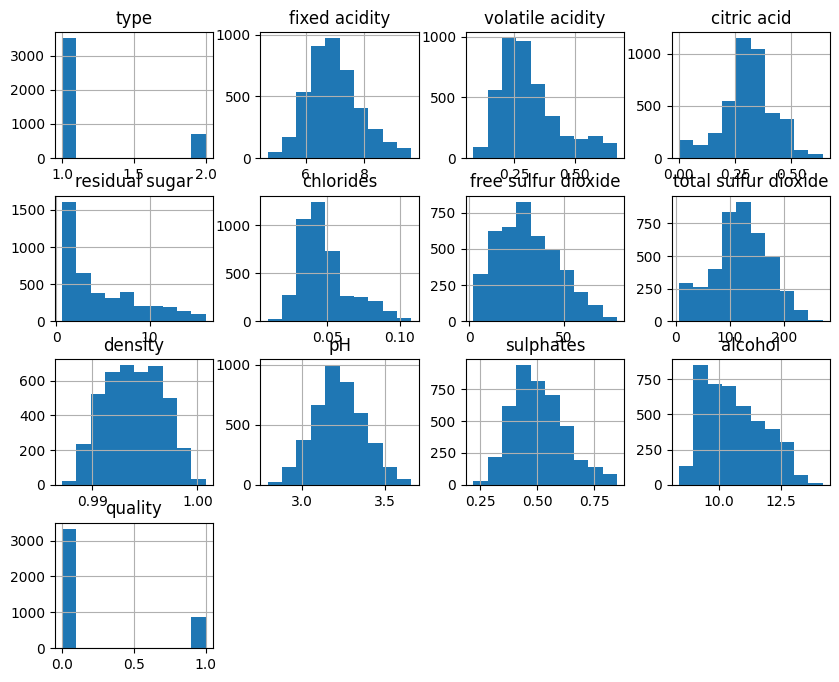

In [498]:
data1.hist(figsize=(10,8));

#### Proporção de dados da categoria alvo

In [499]:
data1['quality'].value_counts() / len(data1) * 100

quality
0    79.315264
1    20.684736
Name: count, dtype: float64

Percebe-se que a proporção de classes da categoria alvo é diferente, se utilizarmos os dados desta forma com certeza impactará nosso modelo negativamente. 

Entretando temos duas saídas, ou passamos o argumento `stratify = True` ao criar o modelo, que fará com que o mesmo separe os dados de treino e teste na mesma proporção (79,3% classe 0 e 20,6 classe 1), ou utilizemos os métodos de Oversampling ou UnderSampling que iguala as classes, ambas as formas possuem vantagens e desvantagens:

**Stratify:**
- O modelo aprende usando as proporções reais do problema.
- Reflete melhor o comportamento do mundo real, especialmente quando as classes desbalanceadas são naturais.
- O modelo pode ser enviesado pela classe marjoritária.
- Métricas como acurácia podem ser enganosas
- Normalmente utilizado quando o objetivo é ter previsões que reflitam o cenário real.

**OverSmapling e Undersampling:**
- O OverSampling aumenta a classe minoritária, duplicando ouy sintetizando exemplos. 
- O UnderSampling diminui a classe marjoritária, removendo alguns exemplos.
- Ajuda o modelo a ficar menos tentêncioso, ajudando a classe minoritária ter mais evidencia.
- Pode melhorar técnicas como F1-Score, Recall e Precision da classe minoritária.
- O OS pode aumentar a chande de overfitting (quando o algorítmo aprende demais sobre um determinado dado), já que temos dados duplicados.
- O US perde informação, já que estamos excluindo dados para que as classes sejam balanceadas.
- O OS deve ser utilizado quando estamos buscando melhorar o desempenho do modelo para identificar classes minoritárias (Ex.: Detecção de fraudes, diagnóstico médico entre outros)
- O US é utilizado quando o desbalanceamento é extremo (Ex.: 99% vs 1%)

Desta forma concluímos que para nosso projeto e melhor forma para lidar com este desequilibrio de classes é utilizando o stratify.

#### Dividindo treino e teste

In [500]:
x = data1.drop(columns='quality', axis=1)

y = data1['quality'] # alvo

In [501]:
# separando teste
x, x_test, y, y_test = train_test_split(x, y, random_state=1, test_size=0.2, stratify=y)

# separando treino e validação
x_train, x_val, y_train, y_val = train_test_split(x,y, random_state=1, test_size=0.2, stratify=y)

# Dummy Classifier (Modelo de Base)

O modelo mais simples de classificar os dados é simplesmente utilizar um algoritmo que chuta todas as classificações para a classe que tem maior frequência. Esse algoritmo serve como critério de comparação, para identificar se os outros modelos tem um desempenho melhor que a classificação mais simples possível. 

In [502]:
# definindo modelo
dummy = DummyClassifier()

# ajustando modelo aos dados
dummy.fit(x, y)

# avaliação
dummy.score(x_test, y_test)

0.7933491686460807

O modelo gerou uma taxa de acerto de 79%. Isso nos informa que os modelos mais robustos a seguir precisam ter uma taxa de acerto maior.

____

# Árvore de Decisão

Para o modelo de árvore de decisão um dos parâmetros mais importante é o `max_depth` (produndidade dos nós), porém esse valor varia conforme os dados e não possui um valor padrão correto. Para descobrir o melhor valor para este parâmetro utilizaremos o GridSearchCV, que é uma ferramenta do Scikit-Learn usada para encontrar os melhores hiperparâmetros de um modelo, garantindo que o ajuste seja feito de maneira robusta usando validação cruzada.

#### GridSearchCV

In [503]:
# definindo os parâmetros a serem testados
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3,4,5,10],
    'min_samples_split': [2,5,10]
}

# confirgura o gridsearchcv
grid_s = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# trina o gridsearch
grid_s.fit(x,y)

# exibe os melhores hiperparâmetros
print('Melhores hiperparâmetros:', grid_s.best_params_)

# melhor modelo
best_model = grid_s.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


In [504]:
# definindo modelo
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=2, random_state=1)

# ajusta o modelo aos dados
model_dt.fit(x_train, y_train)

# avalia modelo nos dados de treino
print(f'Acurácia de treino:{model_dt.score(x_train, y_train)}')
print(f'Acurácia de validação: {model_dt.score(x_val, y_val)}')

Acurácia de treino:0.8394648829431438
Acurácia de validação: 0.8112927191679049


Analisando a acurácia do modelo de treino, vemos que o modelo não "decora" os dados e erra em alguns tendo a pontuação de 83%, e quando passa para a validação, que é a simulação de dados novos, o modelo perde pouco desempenho (o que é normal) mas se mantem com uma boa acurácia.

#### Matriz de Confusão

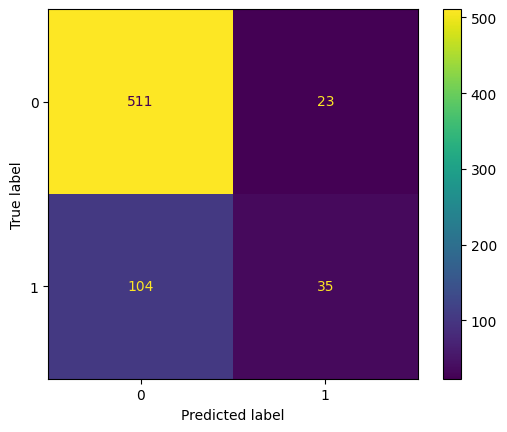

In [505]:
# matriz de confusão
y_pred = model_dt.predict(x_val)

# define matriz de confusão
matriz_confusao = confusion_matrix(y_val, y_pred)

# visualizando matriz de confusão
viz = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao)
viz.plot();

A matriz de confusão nos permite entender qual a quantidade de erros e acertos das previsões de um modelo. ao invés de nos mostrar uma taxa de acerto geral, a matriz é capaz de fornecer informações em uma vizualização para cada uma das categorias da variável alvo.

No nosso modelo podemos observar que a matriz identificou 35 verdadeiros positivos (35 vinhos bons que o modelo acertou) e acertou 511 verdadeiros negativos (vinhos ruins que o modelo classificou como ruim). Porém o modelo também classificou 104 vinhos bons como se fossem ruins (Falsos Negativos), o que nos indica que o modelo não está sabendo diferenciar bem as classes.

In [506]:
print(f'Precisão: {precision_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')

Precisão: 0.603448275862069
Recall: 0.2517985611510791


In [507]:
print(f'F1-Score: {f1_score(y_val, y_pred)}')

F1-Score: 0.35532994923857864


A `precision` calcula a quantidade de dados positivos que o modelo realmente previu como positivo, além disso o risco de detectar um falso positivo (vinho ruim que foi classificado como bom) é bastante alto e impactaria negativamente o negócio.

O `recall` é utilizado quando o risco ou custo de classificar falsos negativos é alto. Por exemplo em casos de diagnósticos de doenças graves, em que é fundamental detectar a presença corretamente de doença.

O `f1-score` fornece o equilibrio entre precision e recall, sendo útil quando as classes alvo estão desbalanceadas, quando uma quantidade de dados é muito diferente para cada classe. Também é aplicavel quando o custo de FP e FN é alto simuntâneamente.

Dito isso, notamos que o modelo apresenta uma precisão de aproximadamente 60%, o que é uma taxa indesejada por ser baixa e nos indica que poderiamos testar outros ajustes ou talvez não seja o melhor modelo para utilizar-mos.

#### Curva ROC

A curva ROC é uma ferramenta gráficausada na análise de modelos de classificação e avaliação do seu desempenho. Ela mede a capacidade do modelo em distinguir entre classes, apresentando uma visão detalhada do trade-off entre o `recall` e a especificidade.

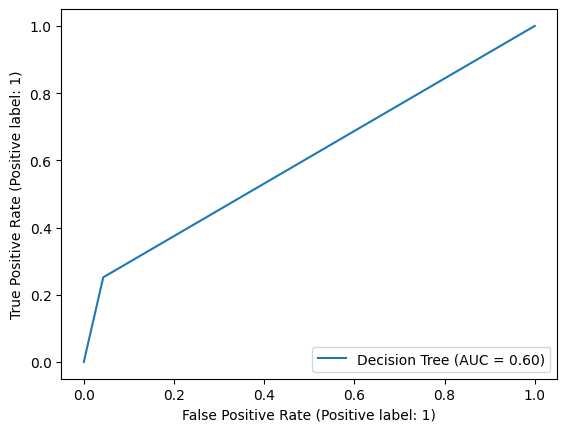

In [508]:
# Exibe o gráfico da curva roc
RocCurveDisplay.from_predictions(y_val, y_pred, name= "Decision Tree");

Quanto mais próximo de 1 no eixo Y, melhor o desempenho do modelo, onde é encontrado um alto valor de TPR (Taxa de Verdadeiros Positivos). No nosso gráfico observamos que não é bem o que acontece, a curva está mais próxima do valor 0 (FPR ou Taxa de Falsos Positivos), indicando que o modelo não está classificando bem os dados.

In [509]:
# exibe AUC
print(f'AUC: {roc_auc_score(y_val, y_pred)}')

AUC: 0.604363700051195


O AUC (Área sob a Curva) é um número entre 0 e 1 que resume o desempenho do modelo:
- AUC = 1: Modelo perfeito (separa completamente as classes).
- AUC = 0.5: Modelo sem poder descriminativo (equivalente a uma cllassificação aleatória).
- AUC < 0.5: Modelo com desempenho pior que aleatório (possivelmente está invertendo classes)

Nosso AUC é um pouco melhor que um modelo aletório, mas não bom o suficiente para ser um bom modelo de classificação para esses dados.

#### Relatório de Métricas

In [510]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       534
           1       0.60      0.25      0.36       139

    accuracy                           0.81       673
   macro avg       0.72      0.60      0.62       673
weighted avg       0.78      0.81      0.78       673



#### Validação Cruzada

A validação cruzada também é uma forma de avaliar desempenho de um modelo de machine learning, que divide os dados em partes para treinar e testar o modelo várias vezes, ela garante que cada divisão dos dados será utilizada para o treino quanto para a validação, e o resultado deve ser a média da métrica escolhida.

Vantagens:
- Reduz o risco de overfitting e underfitting ao avaliar o modelo em diferentes divisões dos dados.
- Garante que o desempenho do modelo não aprenda de uma única divisão dos dados (como em um punico conjunto de teste).
- Útil quando os dados disponíveis são limitados.

Desvantagens:
- Para grande volumes de dados ou modelos mais complexos, o processo pode ser demorado, já que o modelo é treinado várias vezes.
- Embora a validação cruzada minimize a dependência da divisão inicial, ela pode depender da qualidade da divisão inicial dos folds.

#### VC com KFold

In [511]:
# inicializando um segundo modelo
model_dt2 = DecisionTreeClassifier(max_depth=5)

# atribuindo número de divisões
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados
cv_results = cross_validate(model_dt2, x, y, cv=kf)
cv_results

{'fit_time': array([0.        , 0.01115417, 0.        , 0.        , 0.01562643]),
 'score_time': array([0.01562643, 0.00081897, 0.01303053, 0.        , 0.        ]),
 'test_score': array([0.80534918, 0.80980684, 0.81426449, 0.81575037, 0.80059524])}

In [512]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()

print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.7979181198246321, 0.820388326082111]


#### VC KFold Stratified

In [513]:
# proporção de classes
data1['quality'].value_counts(normalize=True)

quality
0    0.793153
1    0.206847
Name: proportion, dtype: float64

In [514]:
model_dt3 = DecisionTreeClassifier(max_depth=5)

# define stratfiedkfold
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# armazena os resultados
cv_results = cross_validate(model_dt3, x, y, cv=skf)

In [515]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.8031225049333595, 0.8324343478226017]


Com a validação cruzada estratificada nós conseguimos ter uma segurança maior em dizer que o desempenho do modelo é entre 80 a 83% de acurácia, porém isso não melhora o desempenho própriamente.

#### Melhorando o desempenho do modelo

#### OverSampling

Por padrão o oversampling iria duplicar os dados de menor classe até se equiparar em quantidade ao de maior classe, o que poderia gerar um problema de enviesamento. Portanto utilizaremos um outro método chamado de Smote, esse método irá criar novos dados sintéticos com um padrão parecido com os da classe desejada, assim o modelo irá entender um pouco mais o padrão dos dados e poderá separar mais as classes.

In [516]:
# define método smote
oversample = SMOTE()

# cria variáveis balanceadas pelo método
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

In [517]:
# checando balanceamento
y_balanceado.value_counts(normalize=True)

quality
1    0.5
0    0.5
Name: proportion, dtype: float64

Perfeitamente balanceado!

In [518]:
# atribuindo modelo
model_dt4 = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=2, random_state=1)

# atribuindo kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados da validação cruzada
cv_results = cross_validate(model_dt4, x_balanceado, y_balanceado, cv=skf)

In [519]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.7389071673495778, 0.7779534344988611]


O desemepnho do modelo certamente melhorou, no primeiro modelo que criamos a acurácia foi de aproximadamente 60%, neste último temos um intervalo de confiança de 74% a 77%.

Todavia, os dados foram avalidados em dados balanceados, e no mundo real dificilmente será desta forma. Este modelo serve apenas para o algorítmo aprender sobre os dados, mas quando passar para etpa de avaliação precisamos checar em dados desbalanceados.

#### Pipeline

Precisamos criar um pipeline que avalie o modelo com os dados desbalanceados.

Uma observação aqui é que importamos o método Pipeline da biblioteca imblearn, mesmo a scikit-learn também ter seu próprio método de pipeline. Fizemos isso pois estamos utilizando o SMOTE da imblearn, e caso pegassemos o método da sklearn poderíamos ter problemas.

In [520]:
model_dt5 = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=1, min_samples_split=2)

# criando pipeline
pipeline = imbpipeline([('oversample', SMOTE()), ('Tree', model_dt5)])

In [521]:
# atribuindo kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

In [522]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.654952895577848, 0.7433887516308127]


Notamos que desta forma o intervalo de confiança diminuiu um pouco, indo para 64% a 75%. Mas isso já era esperado pois os dados reais não virão balanceados, e o modelo anterior estava avaliando dados balanceados.

#### UnderSampling

O undersampling por padrão iria remover dados majoritários aleatóriamente até ter a mesma quantidade de dados pra cada classe, isso nos resultaria em problemas pois haveria o risco de remover dados importantes e gerar perda de informação. O método que utilizaremos possui uma estratégia de escolher os elementos que possuem características parecidas com os elementos da outra classe, dessa maneira o modelo vai tentar identificar qual que é a diferença de uma classe para a outra.

In [523]:
model_dt6 = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=1, min_samples_split=2)

# criando pipeline
pipeline = imbpipeline([('undersample', NearMiss(version=3)), ('Tree', model_dt6)])

In [524]:
# atribuindo kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

In [525]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.6673512203099783, 0.7286209724304165]


O resultado deste método foi inferior ao método utilizando oversampling, que por sua vez será o escolhido para o modelo.

#### Testando Modelo

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       668
           1       0.39      0.82      0.53       174

    accuracy                           0.70       842
   macro avg       0.66      0.74      0.66       842
weighted avg       0.82      0.70      0.73       842



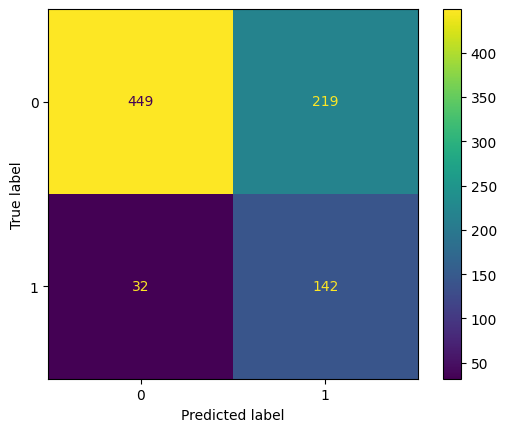

In [526]:
# inicizalizando oversampling
oversample = SMOTE()

# balanceando variáveis
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

# iniciando modelo
model_dt_final = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=2, random_state=1)

# ajustando modelo aos dados
model_dt_final.fit(x_balanceado, y_balanceado)

# armazenando valores preditos
y_pred = model_dt_final.predict(x_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

Esta última versão do modelo  de árvore de decisão trouxe melhoras significativas, vizualisando a matriz de confusão conseguimos notar que o modelo está acertando mais verdadeiros positivos e verdadeiros negativos que o primeiro modelo. O intervalo de confiança do modelo está entre 66% e 72% acurácia, e com recall de 73%

____

# Regressão Logística

A regressão logística é um algoritmo supervisionado usado principalmente em classificação binária, mas também pode ser utilizada em multiclasses. Apesar do nome, ela é uma técnica de classificação, não de regressão. O modelo prevê a probabilidade de uma amostra pertencer a uma classes específica, com base em um conjunto de variáveis independentes. A regressão logística também é bastante sensível à escala dos dados e a outliers, por tanto é sempre vantajoso normalizar os dados antes de aplicar o modelo, e para normaliza-los estarei atribuindo uma etapa de normalização com StandardScaler na pipeline de treinamento.

In [527]:
# atribuindo modelo
model_lr = LogisticRegression()

# pipeline de treinamente
logistic_pipeline = make_pipeline(StandardScaler(), model_lr)

# ajustando aos dados de treino
logistic_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

**StandardScaler:**

- É uma técnica de pre-processamento de dados usada para padronizar as variáveis numéricas. Ele ajusta os valores das variáveis para que tenham média 0 e desvio padrão 1, criando uma distribuição normal.

- Melhora o desempenho de algorítmos como Regressão Logística, SVM, Redes Neurais. A padronização permite que os dados estejam na mesma escala, evitando que outliers atrapalhem o modelo.

- A padronização preserva a forma da distribuição (mantém a relação entre os dados), mas ajusta a escala.


Resultado de modelo de regressão logística sem alterar hiperparâmetros.
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       668
           1       0.61      0.34      0.44       174

    accuracy                           0.82       842
   macro avg       0.73      0.64      0.66       842
weighted avg       0.80      0.82      0.80       842



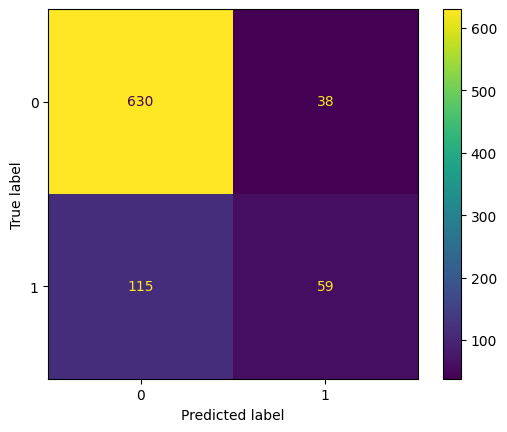

In [528]:
# prevendo resultados
y_pred = logistic_pipeline.predict(x_test)

# exibe tabela de métricas
print('Resultado de modelo de regressão logística sem alterar hiperparâmetros.')
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

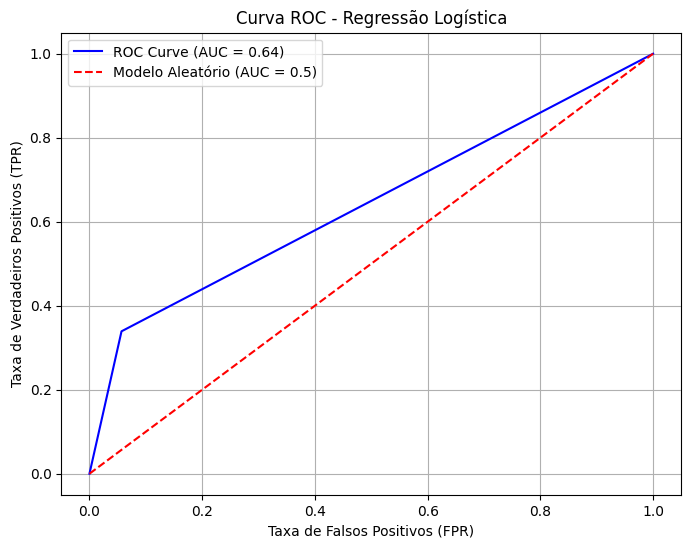

In [529]:
# calcula vlores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# calcula AUC (área sob a curva)
auc = roc_auc_score(y_test,y_pred)

# plota curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--', label= 'Modelo Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.grid()
plt.show()

**Buscando melhores hiperparâmetros para regressão logística**

In [530]:
# define número máximo de iterações
max_iter = np.linspace(100,300, 5, dtype=int)

# define força de regularização
c = [0.001, 0.01, 0.1, 1, 10]

# define validação cruzada com stratfiedkfold
cv = StratifiedKFold(shuffle=True, random_state=1) 

# definindo os parâmetros a serem testados
param_grid_lr = [
{
    'logisticregression__solver' : ['newton-cg', 'lbfgs'],
    'logisticregression__penalty' : ['l2'],
    'logisticregression__max_iter' : max_iter,
    'logisticregression__C' : c
},
{
    'logisticregression__solver' : ['liblinear'],
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__max_iter' : max_iter,
    'logisticregression__C' : c
}
]

In [531]:
# aplica os parâmetros no gridsearch
lr_grid_search = GridSearchCV(estimator=logistic_pipeline,
                              param_grid=param_grid_lr,
                              scoring='precision',
                              n_jobs=-1,
                              cv=cv)

# Treina os dados com os parâmetros fornecidos
lr_grid_search.fit(x_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l2'],
                          'logisticregression__solver': ['newton-cg', 'lbfgs']},
                         {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l1', 'l2'],
                          'logisticregression__solver': ['liblinear']}],
             scoring='precision')

In [532]:
# exibe os melhores hiperparâmetros
lr_grid_search.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [533]:
# definindo segunda ver~soa do modelo de regressão logística
model_lr2 = LogisticRegression(C=0.01, max_iter=100, penalty='l1', solver='liblinear')

# pipeline de treinamente
logistic_pipeline = make_pipeline(StandardScaler(), model_lr2)

# ajustando aos dados de treino
logistic_pipeline.fit(x_train, y_train)

# prevendo resultados
y_pred = logistic_pipeline.predict(x_test)

# exibe tabela de métricas
print('Resultado de modelo de regressão logística sem alterar hiperparâmetros.')
print(classification_report(y_test,y_pred))

Resultado de modelo de regressão logística sem alterar hiperparâmetros.
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       668
           1       0.59      0.15      0.24       174

    accuracy                           0.80       842
   macro avg       0.70      0.56      0.56       842
weighted avg       0.77      0.80      0.75       842



In [534]:
# verificando proporção de classes
y_train.value_counts(normalize=True)

quality
0    0.793014
1    0.206986
Name: proportion, dtype: float64

A precisão média está em torno de 70%. Novamente os dados podem não estar sendo bem separados devido a proporção de classes.

#### Testando resultados com OverSampling

In [535]:
# define método smote
oversample = SMOTE()

# cria variáveis balanceadas pelo método
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

In [536]:
# checando balanceamento
y_balanceado.value_counts(normalize=True)

quality
1    0.5
0    0.5
Name: proportion, dtype: float64

In [537]:
# criando pipeline
pipeline = imbpipeline([('scaler', StandardScaler()),('oversample', SMOTE()), ('logistic', model_lr2)])

In [538]:
# atribuindo kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

In [539]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.6736247992892956, 0.755629428404754]


#### Testando resultados com UnderSampling

In [540]:
# criando pipeline
pipeline = imbpipeline([('scaler', StandardScaler()),('undersample', NearMiss(version=3)), ('lr', model_lr2)])

In [541]:
# atribuindo kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

In [542]:
media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.6575345526424111, 0.696212882438605]


Com oversample tivemos um intervalo de confiança em relação a acurácia maior, portanto será o método que utilizaremos.

              precision    recall  f1-score   support

           0       0.89      0.69      0.78       668
           1       0.36      0.68      0.47       174

    accuracy                           0.69       842
   macro avg       0.63      0.68      0.63       842
weighted avg       0.78      0.69      0.72       842



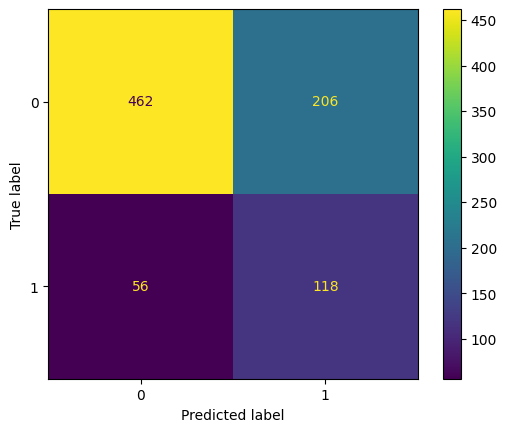

In [543]:
# ajustando dados desbalanceados
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

# ajusta modelo aos dados
model_lr2.fit(x_balanceado, y_balanceado)

# prever os valores
y_pred = model_lr2.predict(x_test)

# exibe matriz de confusão e tabela de métricas
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

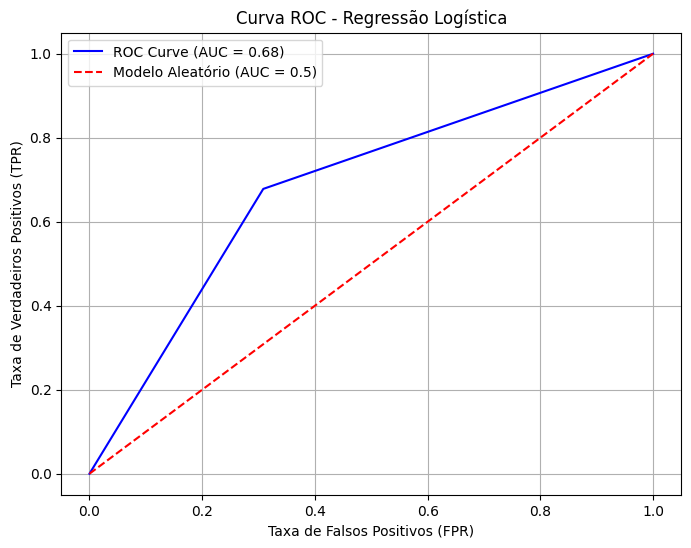

In [544]:
# calcula vlores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# calcula AUC (área sob a curva)
auc = roc_auc_score(y_test,y_pred)

# plota curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--', label= 'Modelo Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.grid()
plt.show()

Comparado ao primeiro modelo de regressão logística, este último conseguiu acertar mais verdadeiros positivos, porém ele também passou a errar mais e classificando mais falsos positivos. Isso indica que o modelo não está conseguindo separar bem a classe 1.

Baseado nos resultados que tivemos tanto na curva ROC, acurácia e precisão do modelo, concluímos que com estes parâmetros que testamos o modelo não nos retorna um desempenho desejado, não está conseguindo identificar bem a classe alvo.

____

# SVM (Máquinas de Vetores de Suporte)

O SVM é o modelo de aprendizado supervisionado usado tanto para classificação quanto para regressão. Ele é muito popular devido à sua capacidade de criar classificadores robustos, mesmo com dados complexos ou em problemas de alta dimensionalidade. O SVM trabalha encontrando um hiperplano ótimo que separa as classes de maneira eficaz, maximizando a margem entre elas.

**Vantagens:**
- Funciona bem em problemas de alta dimensionalidade.
- Eficiente em casos onde o número de dimensões é maior que o número de amostras.
- Flexível devido à variedade de funções kernel.
- Robustez contra overfitting, especialmente em problemas com pouca amostra.

**Desvantagens:**
- Computacionalmente caro para grandes conjuntos de dados, já que o tempo de treinamento cresce com o tamanho dos dados.
- Difícil de interpretar quando se usam funções kernel complexas.
- Sensível a dados desbalanceados.

In [545]:
# atribuindo modelo
model_svm = SVC()

# pipeline de treinamento
svm_pipeline = make_pipeline(StandardScaler(), model_svm)

# ajustando aos dados de treino
svm_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [546]:
y_pred = svm_pipeline.predict(x_test)

In [547]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       668
           1       0.64      0.25      0.36       174

    accuracy                           0.82       842
   macro avg       0.73      0.61      0.63       842
weighted avg       0.79      0.82      0.78       842



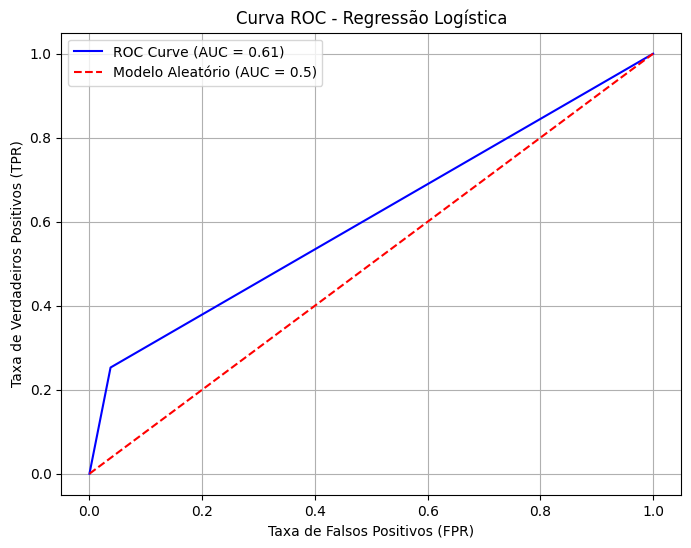

In [548]:
# calcula vlores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# calcula AUC (área sob a curva)
auc = roc_auc_score(y_test,y_pred)

# plota curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--', label= 'Modelo Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend()
plt.grid()
plt.show()

In [549]:
# buscando melhores hiperparâmetros para svm
#param_grid = {
#    'C': [0.01, 0.1, 1, 10, 100],
#    'kernel': ['linear', 'rbf'],
#    'gamma': [1, 0.1, 0.01, 0.001]
#}

# definindo stratfiedkfold
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# configura o gridsearchCV
#svm_grid_search = GridSearchCV(
#    estimator=SVC(), # modelo a ser treinado
#    param_grid=param_grid, # dicionário de parâmetros
#    cv=skf, # utilizando stratfiedkfoldo como validação crusada
#    scoring='precision', # precisão como métrica desejada
#    verbose=1, # exibe progresso no terminal
#    n_jobs=-1 # usa todos os núcleos disponíveis
#)

# treina o modelo
##svm_grid_search.fit(x_train, y_train)

# exibe os melhores parâmetros
#print(svm_grid_search.best_params_)

_Uma observação importante é que essa célula levou 9 minutos para executar na minha máquina, enquanto os modelos anteriores foram poucos segundos, isso ja reforça o fato de que o SVM é um modelo robusto e que exige muito gasto computacional._

In [550]:
model_svm2 = SVC(C=1, gamma=1, kernel='rbf')

# criando pipeline SVM
pipeline = imbpipeline([('scaler', StandardScaler()), ('smv',  model_svm2)])

# trinando dados
pipeline.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smv', SVC(C=1, gamma=1))])

In [551]:
y_pred = pipeline.predict(x_test)

In [552]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       668
           1       0.67      0.23      0.34       174

    accuracy                           0.82       842
   macro avg       0.75      0.60      0.62       842
weighted avg       0.80      0.82      0.78       842



In [553]:
# verificando proporção de classes
y_train.value_counts(normalize=True)

quality
0    0.793014
1    0.206986
Name: proportion, dtype: float64

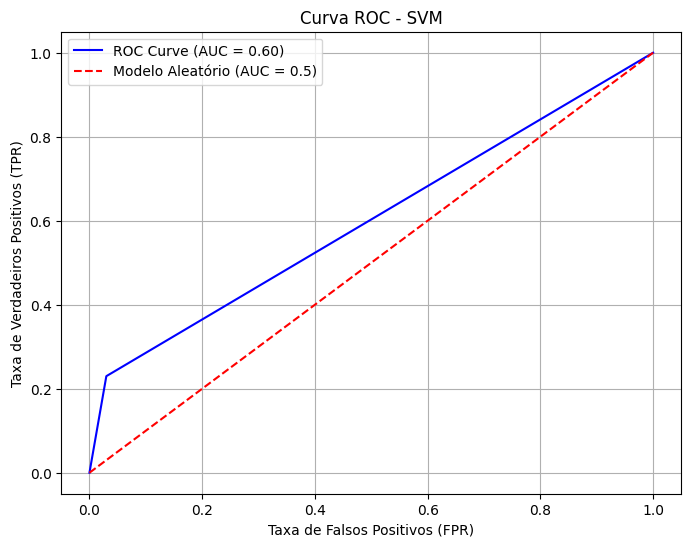

In [554]:
# calcula vlores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# calcula AUC (área sob a curva)
auc = roc_auc_score(y_test,y_pred)

# plota curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--', label= 'Modelo Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend()
plt.grid()
plt.show()

**Testando com oversample e undersample**

In [555]:
# OVERSAMPLING

# cria variáveis balanceadas pelo método
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

# criando pipeline
pipeline = imbpipeline([('scaler', StandardScaler()),('oversample', SMOTE()), ('svm', model_svm2)])

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.796580229564401, 0.8365912485364978]


In [556]:
# UNDERSAMPLING

# criando pipeline
pipeline = imbpipeline([('scaler', StandardScaler()),('undersample', NearMiss(version=3)), ('lr', model_svm2)])

# armazenando resultados da validação cruzada com x e y não balanceados
cv_results = cross_validate(pipeline, x, y, cv=skf)

media = cv_results['test_score'].mean()
desvio_padrao = cv_results['test_score'].std()
print(f'Intervalo de Confiança (Acurácia): [{media - 2* desvio_padrao}, {min(media + 2* desvio_padrao, 1)}]')

Intervalo de Confiança (Acurácia): [0.78022745822695, 0.8131090591437428]


Oversample nos retornou um intervalo de confiança melhor em acurácia.

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       668
           1       0.39      0.09      0.15       174

    accuracy                           0.78       842
   macro avg       0.60      0.53      0.51       842
weighted avg       0.72      0.78      0.73       842



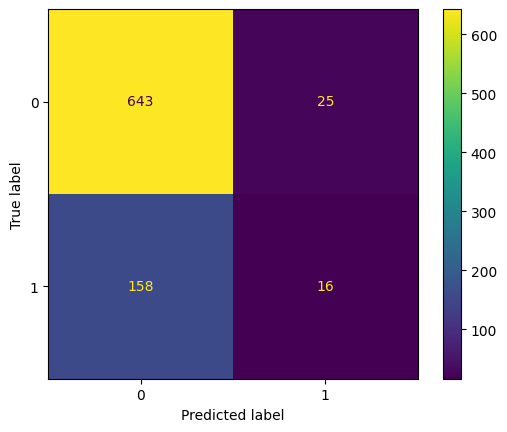

In [557]:
# ajustando dados desbalanceados
x_balanceado, y_balanceado = oversample.fit_resample(x,y)

# ajusta modelo aos dados
model_svm2.fit(x_balanceado, y_balanceado)

# prever os valores
y_pred = model_svm2.predict(x_test)

# exibe matriz de confusão e tabela de métricas
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

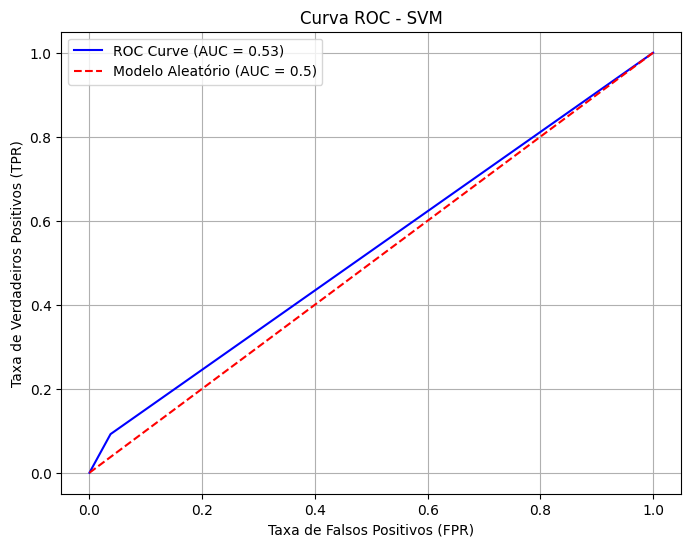

In [558]:
# calcula vlores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# calcula AUC (área sob a curva)
auc = roc_auc_score(y_test,y_pred)

# plota curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--', label= 'Modelo Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend()
plt.grid()
plt.show()

Apesar de o intervalo de confiança em relação à acurácia deste modelo ser a melhor até o momento, ele não é capaz de classificar bem o nosso alvo, a precisão está muito baixa para classificar dados da classe 1.

____

# Redes Neurais Artificiais